# ECSE 415 Assignment 2, Question 2
### Alex Hale | 260672475 | October 20, 2019

## Matching Using SIFT - Book Reveal

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

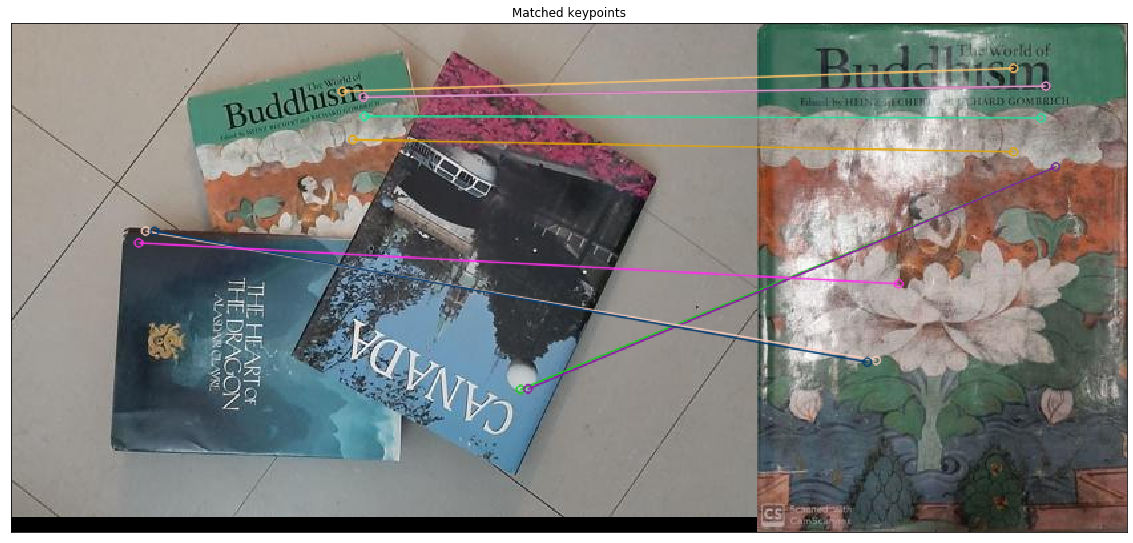

In [4]:
# load images and convert to RGB
book_occ = cv2.imread("book_occlusion.jpg")
book_occ_disp = book_occ.copy()
book_crop = cv2.imread("book_crop.jpg")
book_crop_disp = book_crop.copy()
book_occ = cv2.cvtColor(book_occ, cv2.COLOR_BGR2RGB)
book_crop = cv2.cvtColor(book_crop, cv2.COLOR_BGR2RGB)

# create SIFT and BFMatcher objects
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

# detect SIFT features, with no masks
keypoints_occ, descriptors_occ = sift.detectAndCompute(book_occ, None)
keypoints_crop, descriptors_crop = sift.detectAndCompute(book_crop, None)

# find and draw matches
matches = sorted(bf.match(descriptors_occ, descriptors_crop), key = lambda x:x.distance)
match_lines = cv2.drawMatches(book_occ,keypoints_occ,book_crop,keypoints_crop, matches[:10], None, flags=2)
# cv2.drawKeypoints(book_occ, keypoints_occ, book_occ_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(20,20))
plt.imshow(match_lines)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mp_occ = np.float32([keypoints_occ[i].pt for (__, i) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (i, __) in GoodMatches])

# find homography and wrap image accordingly
H, __ = cv2.findHomography(mp_crop, mp_occ, cv2.RANSAC, 4)
warped_img = cv2.warpPerspective(book_crop, H, (book_crop.shape[1]+book_occ.shape[1],book_crop.shape[0]))
warped_img[:,:book_occ.shape[1],:] = book_crop

plt.figure(figsize=(20,20))
plt.subplot(212)
plt.imshow(warped_img)
plt.title("Non-Occluded image"), plt.xticks([]), plt.yticks([])
plt.show()

ValueError: could not broadcast input array from shape (383,278,3) into shape (383,561,3)